In [1]:
import warnings
warnings.filterwarnings("ignore", message="module 'ml_dtypes'")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow info/warnings

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.utils import class_weight
from tensorflow.keras import Sequential, layers, Input, callbacks
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

> Baseline

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fold 1: Acc=0.723, Prec=0.692, Rec=0.500, F1=0.581, AUC=0.799
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 2: Acc=0.915, Prec=1.000, Rec=0.778, F1=0.875, AUC=0.952
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023A6B00F240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf

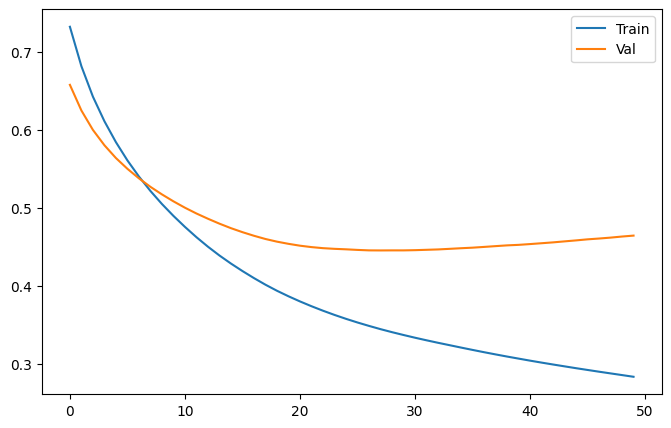

In [2]:
# Reproduceerbaarheid
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Data inladen 
X = pd.read_pickle('X_ontrain_scaled.pkl').values
y = pd.read_pickle('y_ontrain.pkl').values

# cross validatie
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Baseline modeldefinitie: default waarden
def create_model_0(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(8,  activation='relu'),
        layers.Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return model

# Metrics & histories
metrics = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'roc_auc':[]}
histories = []

for fold, (ti,vi) in enumerate(kf.split(X),1):
    X_tr,X_val = X[ti],X[vi]; y_tr,y_val=y[ti],y[vi]
    model = create_model_0(X.shape[1])
    h = model.fit(X_tr,y_tr,epochs=50,batch_size=16,
                  validation_data=(X_val,y_val),verbose=0)
    histories.append(h)
    proba=model.predict(X_val).ravel(); pred=(proba>=0.5).astype(int)
    metrics['accuracy'].append(accuracy_score(y_val,pred))
    metrics['precision'].append(precision_score(y_val,pred,zero_division=0))
    metrics['recall'].append(recall_score(y_val,pred))
    metrics['f1'].append(f1_score(y_val,pred))
    metrics['roc_auc'].append(roc_auc_score(y_val,proba))
    print(f"Fold {fold}: Acc={metrics['accuracy'][-1]:.3f}, "
          f"Prec={metrics['precision'][-1]:.3f}, Rec={metrics['recall'][-1]:.3f}, "
          f"F1={metrics['f1'][-1]:.3f}, AUC={metrics['roc_auc'][-1]:.3f}")

df=pd.DataFrame(metrics,index=[f'Fold {i}'for i in range(1,6)])
df.loc['Mean']=df.mean(); df.loc['Std']=df.std()
print("\nAverage metrics:\n",df)

# Plot loss
avg_tr=np.mean([h.history['loss']     for h in histories],axis=0)
avg_vl=np.mean([h.history['val_loss'] for h in histories],axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_tr,label='Train'); plt.plot(avg_vl,label='Val')
plt.legend(); plt.show()


> Output:

Ik heb een simpel neuraal netwerk getraind met standaardinstellingen (2 verborgen lagen, learning rate 0.001) en 5-fold cross-validatie uitgevoerd. De prestaties zijn wisselend, maar gemiddeld genomen redelijk goed:
- Gemiddelde AUC is 0.87, wat betekent dat het model de klassen goed uit elkaar kan houden.
- F1-score gemiddeld: 0.69, dus de balans tussen precision en recall is oké, maar niet perfect.
- Recall gemiddeld: 0.64, wat iets lager is dan ik zou willen, het model mist dus nog best wat positieve gevallen.
- Precision is gemiddeld: 0.78, dus als het model zegt dat iemand positief is, klopt dat vaak wel.

Er zit wel veel variatie tussen de folds:
In Fold 2 presteert het model heel sterk (AUC 0.95, F1 0.88), maar in Fold 4 is dat duidelijk minder (F1 0.56). Dat kan wijzen op instabiliteit of gevoeligheid voor hoe de data gesplitst is.

Op de loss-curve is ook te zien dat de validatieloss na ongeveer 20 epochs niet echt meer verbetert en daarna zelfs licht oploopt --> mogelijk een begin van overfitting.

> 1: class_weight

In mijn baseline neuraal netwerk merkte ik dat de recall gemiddeld aan de lage kant was (0.64) en er veel variatie tussen de folds zat. Het model miste dus regelmatig positieve gevallen, wat onwenselijk is bij het voorspellen van cardiovasculaire aandoeningen.

Om dit te verbeteren voeg ik in deze iteratie class weights toe, zodat het model meer gewicht geeft aan de zieke klasse tijdens training. Dit helpt om de onbalans in de data te compenseren en het model gevoeliger te maken voor het herkennen van positieven (HVZ).

De netwerkt en hyperparameters blijven verder gelijk aan de baseline, zodat ik het effect van alleen de class weighting goed kan beoordelen.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fold 1: Acc=0.766, Prec=0.733, Rec=0.611, F1=0.667, AUC=0.803
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Fold 2: Acc=0.851, Prec=0.789, Rec=0.833, F1=0.811, AUC=0.946
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Fold 3: Acc=0.830, Prec=0.875, Rec=0.700, F1=0.778, AUC=0.880
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Fold 4: Acc=0.702, Prec=0.455, Rec=0.833, F1=0.588, AUC=0.862
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Fold 5: Acc=0.787, Prec=0.706, Rec=0.706, F1=0.706, AUC=0.843

Model1 Average metrics:
         accuracy  precision    recall        f1   roc_auc
Fold 1  0.765957   0.733333  0.611111  0.666667  0.802682
Fold 2  0.851064   0.789474  0.833333  0.810811  0.946360
Fold 3  0.829787   0.875000  0.700000  0.777778  0.879630
Fold 4  0.702128   0.454545  0.833333  0.588235  0.861905
Fold 5  0.787234   0.705882  0.705882  0.705882  0.843137
Mean    0.787234   0.711647  0.736732  0.709875  0.866743
Std     0.052117   0.140958  0.085727  0.079345  0.047306


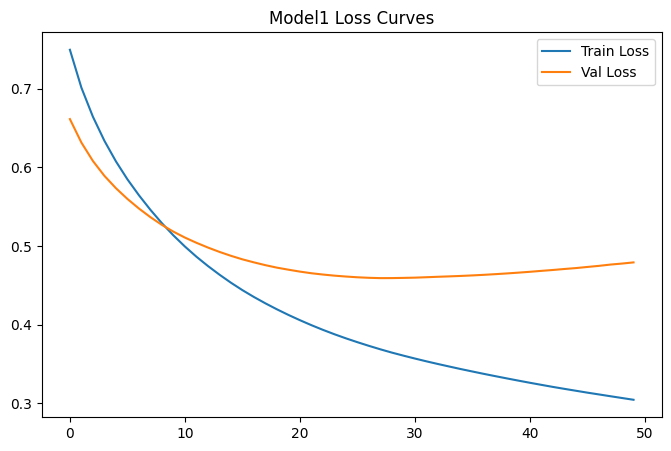

In [4]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.utils import class_weight
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

X = pd.read_pickle('X_ontrain_scaled.pkl').values
y = pd.read_pickle('y_ontrain.pkl').values

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

def create_model_1(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(8,  activation='relu'),
        layers.Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return model

metrics = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'roc_auc':[]}
histories=[]

for fold,(ti,vi) in enumerate(kf.split(X),1):
    X_tr,X_val=X[ti],X[vi]; y_tr,y_val=y[ti],y[vi]
    cw = dict(enumerate(class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_tr), y=y_tr)))
    model = create_model_1(X.shape[1])
    history = model.fit(
        X_tr, y_tr,
        epochs=50,
        batch_size=16,
        validation_data=(X_val, y_val),
        class_weight=cw,
        verbose=0
    )
    histories.append(history)
    proba=model.predict(X_val).ravel(); pred=(proba>=0.5).astype(int)
    metrics['accuracy'].append(accuracy_score(y_val,pred))
    metrics['precision'].append(precision_score(y_val,pred,zero_division=0))
    metrics['recall'].append(recall_score(y_val,pred))
    metrics['f1'].append(f1_score(y_val,pred))
    metrics['roc_auc'].append(roc_auc_score(y_val,proba))
    print(f"Fold {fold}: Acc={metrics['accuracy'][-1]:.3f}, "
          f"Prec={metrics['precision'][-1]:.3f}, Rec={metrics['recall'][-1]:.3f}, "
          f"F1={metrics['f1'][-1]:.3f}, AUC={metrics['roc_auc'][-1]:.3f}")

df1=pd.DataFrame(metrics,index=[f'Fold {i}'for i in range(1,6)])
df1.loc['Mean']=df1.mean(); df1.loc['Std']=df1.std()
print("\nModel1 Average metrics:\n", df1)

avg_tr1=np.mean([h.history['loss'] for h in histories],axis=0)
avg_vl1=np.mean([h.history['val_loss'] for h in histories],axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_tr1, label='Train Loss')
plt.plot(avg_vl1, label='Val Loss')
plt.title('Model1 Loss Curves'); plt.legend(); plt.show()


> Output

In deze iteratie heb ik class weights toegevoegd om het model gevoeliger te maken voor de positieve klasse (HVZ). Dit heeft effect gehad:

- Recall is gestegen naar gemiddeld 0.74, een duidelijke verbetering t.o.v. de baseline (0.64). Dit betekent dat het model nu meer zieke gevallen weet te herkennen.
- De F1-score (0.71) en precision (0.71) zijn goed in balans, wat laat zien dat de verhoging van recall niet ten koste is gegaan van algehele prestatie.
- AUC blijft sterk op 0.87, dus het model blijft goed onderscheid maken tussen de klassen.

Er is nog steeds enige variatie tussen folds:
- Fold 2 en 3 presteren sterk (F1 > 0.77, recall > 0.83).
- Fold 4 laat zien dat een hoge recall (0.83) wel kan samengaan met lagere precision (0.45), maar dat is acceptabel gezien de focus op positieven niet missen.

De loss-curve laat opnieuw zien dat de validatieloss vanaf 25–30 epochs begint te stijgen --> opnieuw een teken van lichte overfitting.

> 2: threshold afstemming

In de vorige iteratie verhoogde ik de gevoeligheid van het neurale netwerk voor de zieke klasse door class weights toe te voegen. Dat werkte goed: de recall ging omhoog naar gemiddeld 0.74, zonder grote daling in precision of F1-score. Wel bleef er nog ruimte voor verbetering in het finetunen van beslissingen.

Standaard gebruikt het model een drempel van 0.5 om te bepalen of iemand positief is of niet. Maar die vaste grens is niet altijd optimaal, zeker niet in een context waar false negatives (gemiste zieken) extra kostbaar zijn.

In deze iteratie bepaal ik per fold de optimale drempelwaarde op basis van de ROC-curve, namelijk het punt waarbij het verschil tussen true positive rate (TPR) en false positive rate (FPR) maximaal is. Zo stem ik het model beter af op de juiste balans tussen gevoeligheid en specificiteit.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Fold 1: Acc=0.809, Prec=0.696, Rec=0.889, F1=0.780, AUC=0.803
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Fold 2: Acc=0.915, Prec=0.938, Rec=0.833, F1=0.882, AUC=0.946
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Fold 3: Acc=0.851, Prec=0.842, Rec=0.800, F1=0.821, AUC=0.880
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fold 4: Acc=0.894, Prec=0.889, Rec=0.667, F1=0.762, AUC=0.862
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fold 5: Acc=0.830, Prec=0.737, Rec=0.824, F1=0.778, AUC=0.843

Model1 Average metrics:
         accuracy  precision    recall        f1   roc_auc
Fold 1  0.808511   0.695652  0.888889  0.780488  0.802682
Fold 2  0.914894   0.937500  0.833333  0.882353  0.946360
Fold 3  0.851064   0.842105  0.800000  0.820513  0.879630
Fold 4  0.893617   0.888889  0.666667  0.761905  0.861905
Fold 5  0.829787   0.736842  0.823529  0.777778  0.843137
Mean    0.859574   0.820198  0.802484  0.804607  0.866743
Std     0.039462   0.091014  0.073909  0.043411  0.047306


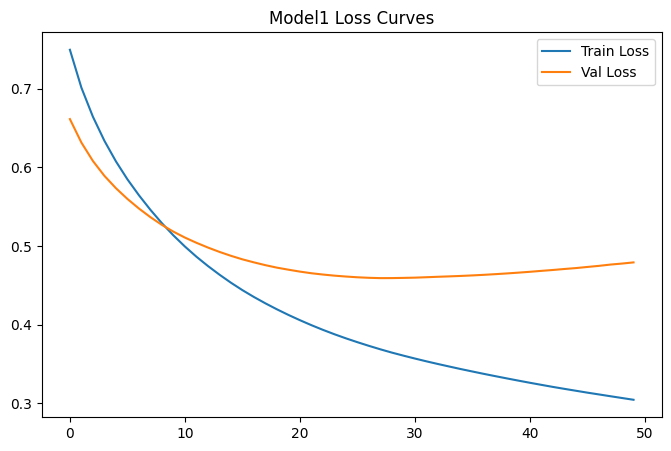

In [5]:
import numpy as np

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

X = pd.read_pickle('X_ontrain_scaled.pkl').values
y = pd.read_pickle('y_ontrain.pkl').values

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

def create_model_1(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(8,  activation='relu'),
        layers.Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return model

metrics = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'roc_auc':[]}
histories=[]

for fold,(ti,vi) in enumerate(kf.split(X),1):
    X_tr,X_val=X[ti],X[vi]; y_tr,y_val=y[ti],y[vi]
    cw = dict(enumerate(class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_tr), y=y_tr)))
    model = create_model_1(X.shape[1])
    history = model.fit(
        X_tr, y_tr,
        epochs=50,
        batch_size=16,
        validation_data=(X_val, y_val),
        class_weight=cw,
        verbose=0
    )
    histories.append(history)

    proba = model.predict(X_val).ravel()
    fpr, tpr, thresholds = roc_curve(y_val, proba)
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    pred = (proba >= best_thresh).astype(int)

    metrics['accuracy'].append(accuracy_score(y_val,pred))
    metrics['precision'].append(precision_score(y_val,pred,zero_division=0))
    metrics['recall'].append(recall_score(y_val,pred))
    metrics['f1'].append(f1_score(y_val,pred))
    metrics['roc_auc'].append(roc_auc_score(y_val,proba))
    print(f"Fold {fold}: Acc={metrics['accuracy'][-1]:.3f}, "
          f"Prec={metrics['precision'][-1]:.3f}, Rec={metrics['recall'][-1]:.3f}, "
          f"F1={metrics['f1'][-1]:.3f}, AUC={metrics['roc_auc'][-1]:.3f}")

df1=pd.DataFrame(metrics,index=[f'Fold {i}'for i in range(1,6)])
df1.loc['Mean']=df1.mean(); df1.loc['Std']=df1.std()
print("\nModel1 Average metrics:\n", df1)

avg_tr1=np.mean([h.history['loss'] for h in histories],axis=0)
avg_vl1=np.mean([h.history['val_loss'] for h in histories],axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_tr1, label='Train Loss')
plt.plot(avg_vl1, label='Val Loss')
plt.title('Model1 Loss Curves'); plt.legend(); plt.show()


> output

Door in deze stap de classificatiedrempel per fold af te stemmen op basis van de ROC-curve (waar TPR - FPR maximaal is), verbeterde de balans tussen precisie en recall merkbaar:
- Gemiddelde recall is nu 0.80, wat betekent dat het model nog beter is geworden in het herkennen van zieke gevallen. Dit was het belangrijkste doel.
- Precision is ook verbeterd naar gemiddeld 0.82, wat aangeeft dat het model niet alleen gevoeliger, maar ook betrouwbaarder is geworden.
- F1-score is gestegen naar 0.80, een mooie balans tussen precision en recall.
- AUC blijft stabiel en hoog op 0.87, wat laat zien dat de algemene discriminatieve kracht van het model behouden blijft.
- Accuracy gemiddeld 0.86, wat hoger is dan in de vorige iteraties.

Wat verder opvalt:
- Fold 1 toont een extreem hoge recall van 0.89, wat laat zien dat de aangepaste drempel echt helpt bij het oppikken van positieven.
- De validatieloss-curve stijgt na 25–30 epochs, wat opnieuw wijst op lichte overfitting richting het einde van de training.

> 3: Dropout toevoegen

In de vorige iteratie verbeterde ik de prestaties van het neurale netwerk door een geoptimaliseerde drempel per fold te gebruiken. Hoewel precision en recall daardoor flink verbeterden, liet de val loss-curve opnieuw zien dat er sprake is van lichte overfitting vanaf ongeveer 25–30 epochs.

Daarom voeg ik in deze iteratie dropoutlagen toe aan het model. Dropout is een veelgebruikte regularisatietechniek die willekeurig neuronen uitschakelt tijdens training, zodat het model minder afhankelijk wordt van specifieke patronen in de trainingsdata. Dit helpt om overfitting te beperken en de generaliseerbaarheid te verbeteren.

De rest van het model blijft ongewijzigd, zodat ik het effect van alleen de dropout goed kan beoordelen.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fold1:Acc=0.766,Prec=0.652,Rec=0.833,F1=0.732,AUC=0.797
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fold2:Acc=0.830,Prec=0.778,Rec=0.778,F1=0.778,AUC=0.891
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Fold3:Acc=0.915,Prec=0.864,Rec=0.950,F1=0.905,AUC=0.917
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Fold4:Acc=0.894,Prec=0.818,Rec=0.750,F1=0.783,AUC=0.907
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Fold5:Acc=0.787,Prec=0.706,Rec=0.706,F1=0.706,AUC=0.822

Model2 Average metrics:
        accuracy  precision    recall        f1   roc_auc
Fold1  0.765957   0.652174  0.833333  0.731707  0.796935
Fold2  0.829787   0.777778  0.777778  0.777778  0.890805
Fold3  0.914894   0.863636  0.950000  0.904762  0.916667
Fold4  0.893617   0.818182  0.750000  0.782609  0.907143
Fold5  0.787234   0.705882  0.705882  0.705882  0.821569
Mean   0.838298   0.763530  0.803399  0.780548  0.866624
Std    0.058035   0.076072  0.084149  0.068413  0.048202


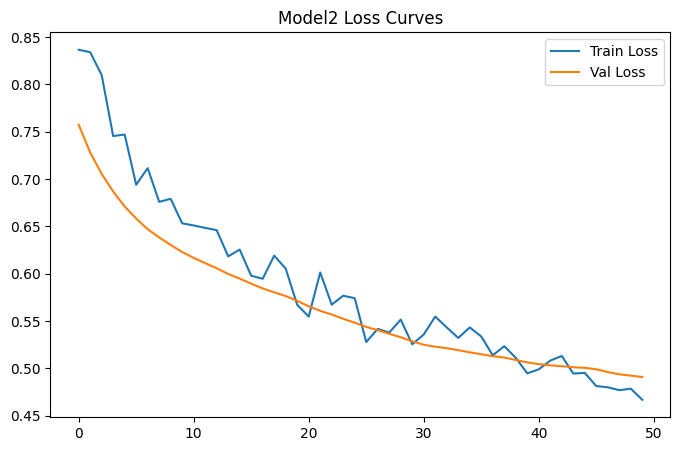

In [6]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.utils import class_weight
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

SEED=42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
X=pd.read_pickle('X_ontrain_scaled.pkl').values
y=pd.read_pickle('y_ontrain.pkl').values
kf=KFold(n_splits=5,shuffle=True,random_state=SEED)

def create_model_2(input_dim):
    model=Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(16,activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(8,activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1,activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3),loss='binary_crossentropy')
    return model

metrics={'accuracy':[],'precision':[],'recall':[],'f1':[],'roc_auc':[]}
histories=[]

for fold,(ti,vi) in enumerate(kf.split(X),1):
    X_tr,X_val=X[ti],X[vi]; y_tr,y_val=y[ti],y[vi]
    cw=dict(enumerate(class_weight.compute_class_weight(
        'balanced',classes=np.unique(y_tr),y=y_tr)))
    model=create_model_2(X.shape[1])
    history=model.fit(
        X_tr,y_tr,epochs=50,batch_size=16,
        validation_data=(X_val,y_val),
        class_weight=cw,verbose=0
    )
    histories.append(history)

    proba = model.predict(X_val).ravel()
    fpr, tpr, thresholds = roc_curve(y_val, proba)
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    pred = (proba >= best_thresh).astype(int)

    metrics['accuracy'].append(accuracy_score(y_val,pred))
    metrics['precision'].append(precision_score(y_val,pred,zero_division=0))
    metrics['recall'].append(recall_score(y_val,pred))
    metrics['f1'].append(f1_score(y_val,pred))
    metrics['roc_auc'].append(roc_auc_score(y_val,proba))
    print(f"Fold{fold}:Acc={metrics['accuracy'][-1]:.3f},Prec={metrics['precision'][-1]:.3f},Rec={metrics['recall'][-1]:.3f},F1={metrics['f1'][-1]:.3f},AUC={metrics['roc_auc'][-1]:.3f}")

df2=pd.DataFrame(metrics,index=[f'Fold{i}'for i in range(1,6)])
df2.loc['Mean']=df2.mean();df2.loc['Std']=df2.std()
print("\nModel2 Average metrics:\n",df2)

avg_tr2=np.mean([h.history['loss']for h in histories],axis=0)
avg_vl2=np.mean([h.history['val_loss']for h in histories],axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_tr2,label='Train Loss');plt.plot(avg_vl2,label='Val Loss')
plt.title('Model2 Loss Curves');plt.legend();plt.show()


> Output

In deze iteratie heb ik dropoutlagen toegevoegd om overfitting tegen te gaan. Het doel was om de generalisatie van het model te verbeteren, vooral omdat eerdere versies na 25–30 epochs begonnen te overfitten.

De resultaten laten zien dat het model nog steeds sterk presteert, met goede scores op alle metrics:
- Gemiddelde recall is 0.80, wat aangeeft dat het model nog altijd goed is in het herkennen van zieke gevallen.
- Precision ligt op 0.76, iets lager dan in de vorige iteratie, maar nog steeds solide.
- F1-score is gemiddeld 0.78, dus de balans tussen precision en recall blijft goed.
- ROC AUC is 0.87, vergelijkbaar met eerdere versies — het model blijft goed onderscheid maken.
- Accuracy is gemiddeld 0.84, met uitschieters tot boven de 0.91.

Opvallend is Fold 3, met een F1-score van 0.91 en recall van 0.95 --> een topresultaat.

Wat verder belangrijk is: de val loss-curve (te zien in de plot) lijkt iets vlakker te blijven richting het einde van de training, wat erop wijst dat de dropout inderdaad helpt om overfitting iets te temperen.


> 4: Netwerk uitbreiden

In de vorige iteratie heb ik met behulp van dropout de overfitting kunnen beperken, terwijl de prestaties (vooral recall) goed bleven. Om nu te onderzoeken of het model ook inhoudelijk krachtiger kan worden, kies ik ervoor om het netwerk groter en dieper te maken.

In deze iteratie vergroot ik het aantal neuronen en voeg ik een extra laag toe:
- Van 2 --> 3 hidden layers
- Meer units per laag (32 --> 16 --> 8)
- Dropout blijft aanwezig om overfitting tegen te gaan

Doel: kijken of dit uitgebreidere model in staat is om complexere patronen in de data te herkennen en zo de prestaties verder te verbeteren, zonder verlies aan generalisatie.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Fold1:Acc=0.766,Prec=0.706,Rec=0.667,F1=0.686,AUC=0.799
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold2:Acc=0.809,Prec=0.714,Rec=0.833,F1=0.769,AUC=0.916
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold3:Acc=0.894,Prec=0.941,Rec=0.800,F1=0.865,AUC=0.933
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold4:Acc=0.787,Prec=0.545,Rec=1.000,F1=0.706,AUC=0.917
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Fold5:Acc=0.723,Prec=0.625,Rec=0.588,F1=0.606,AUC=0.831

Model3 Average metrics:
        accuracy  precision    recall        f1   roc_auc
Fold1  0.765957   0.705882  0.666667  0.685714  0.798851
Fold2  0.808511   0.714286  0.833333  0.769231  0.915709
Fold3  0.893617   0.941176  0.800000  0.864865  0.933333
Fold4  0.787234   0.545455  1.000000  0.705882  0.916667
Fold5  0.723404   0.625000  0.

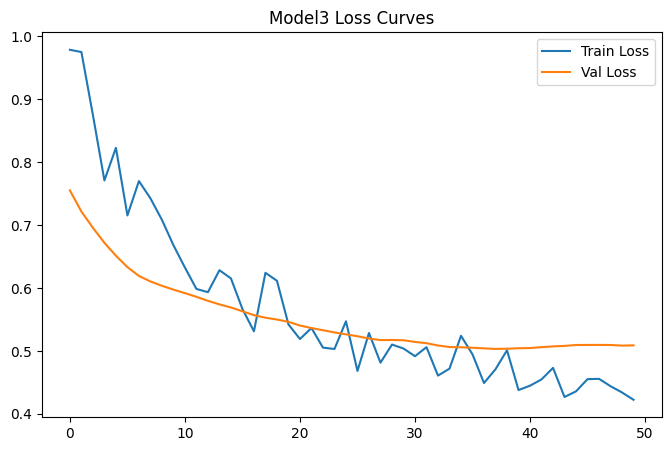

In [7]:
SEED=42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
X=pd.read_pickle('X_ontrain_scaled.pkl').values
y=pd.read_pickle('y_ontrain.pkl').values
kf=KFold(n_splits=5,shuffle=True,random_state=SEED)

def create_model_3(input_dim):
    model=Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(32,activation='relu'),layers.Dropout(0.4),
        layers.Dense(16,activation='relu'),layers.Dropout(0.4),
        layers.Dense(8, activation='relu'),layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3),loss='binary_crossentropy')
    return model

metrics={'accuracy':[],'precision':[],'recall':[],'f1':[],'roc_auc':[]}
histories=[]

for fold,(ti,vi) in enumerate(kf.split(X),1):
    X_tr,X_val=X[ti],X[vi]; y_tr,y_val=y[ti],y[vi]
    cw=dict(enumerate(class_weight.compute_class_weight(
        'balanced',classes=np.unique(y_tr),y=y_tr)))
    model=create_model_3(X.shape[1])
    h=model.fit(
        X_tr,y_tr,epochs=50,batch_size=16,
        validation_data=(X_val,y_val),
        class_weight=cw,verbose=0
    )
    histories.append(history)

    proba = model.predict(X_val).ravel()
    fpr, tpr, thresholds = roc_curve(y_val, proba)
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    pred = (proba >= best_thresh).astype(int)

    proba=model.predict(X_val).ravel(); pred=(proba>=0.5).astype(int)
    metrics['accuracy'].append(accuracy_score(y_val,pred))
    metrics['precision'].append(precision_score(y_val,pred,zero_division=0))
    metrics['recall'].append(recall_score(y_val,pred))
    metrics['f1'].append(f1_score(y_val,pred))
    metrics['roc_auc'].append(roc_auc_score(y_val,proba))
    print(f"Fold{fold}:Acc={metrics['accuracy'][-1]:.3f},Prec={metrics['precision'][-1]:.3f},Rec={metrics['recall'][-1]:.3f},F1={metrics['f1'][-1]:.3f},AUC={metrics['roc_auc'][-1]:.3f}")

df3=pd.DataFrame(metrics,index=[f'Fold{i}'for i in range(1,6)])
df3.loc['Mean']=df3.mean();df3.loc['Std']=df3.std()
print("\nModel3 Average metrics:\n",df3)

avg_tr3=np.mean([h.history['loss']for h in histories],axis=0)
avg_vl3=np.mean([h.history['val_loss']for h in histories],axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_tr3,label='Train Loss');plt.plot(avg_vl3,label='Val Loss')
plt.title('Model3 Loss Curves');plt.legend();plt.show()


> Output

In deze iteratie werd het neuraal netwerk uitgebreid met meer lagen en neuronen, in de hoop dat het model complexere patronen zou kunnen oppikken. De prestaties laten een gemengd beeld zien:
- Recall blijft goed op gemiddeld 0.78, dus het model blijft relatief goed in het herkennen van zieke gevallen.
- Precision daalt iets naar 0.71 gemiddeld, met grote variatie tussen de folds (bijv. 0.94 in fold 3 vs. 0.54 in fold 4).
- F1-score gemiddeld: 0.73, iets lager dan in de vorige iteratie (0.78).
- AUC blijft sterk op 0.88, wat betekent dat het model nog steeds goed onderscheid maakt tussen positief en negatief.
- Accuracy gemiddeld: 0.80, vergelijkbaar met eerdere modellen.

De loss-curves tonen een relatief stabiel verloop met minder duidelijke overfitting dan in eerdere modellen, mede dankzij de combinatie van dropout en bredere structuur. Toch is er meer instabiliteit zichtbaar in de individuele prestaties per fold.

Opvallend:
- Fold 3 is opnieuw zeer sterk (F1: 0.86, AUC: 0.93).
- Fold 4 laat een extreem hoge recall zien (1.00), maar de lage precision (0.55) wijst op veel false positives.
- Fold 5 scoort het zwakst over de hele linie.

> 5: Leaky ReLu functie

In de vorige iteratie maakte ik het netwerk dieper en breder. Hoewel de prestaties redelijk bleven, leidde de hogere complexiteit soms tot wisselvallige resultaten en mogelijk dode neuronen, een bekend probleem bij ReLU, waarbij sommige neuronen volledig blijven hangen op nul.

Daarom vervang ik in deze iteratie de ReLU-activatiefuncties door Leaky ReLU, die kleine negatieve waardes doorlaat en zo voorkomt dat neuronen volledig inactief raken. Het model blijft verder gelijk:
- 3 hidden layers
- Dropout om overfitting te beperken
- Class weights en ROC-drempelselectie blijven actief

Doel: kijken of Leaky ReLU de training stabieler maakt en zo leidt tot betere en consistentere prestaties, vooral op recall en F1.

c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fold 1: Acc=0.787, Prec=0.700, Rec=0.778, F1=0.737, AUC=0.795


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Fold 2: Acc=0.809, Prec=0.714, Rec=0.833, F1=0.769, AUC=0.927


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Fold 3: Acc=0.915, Prec=0.944, Rec=0.850, F1=0.895, AUC=0.933


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Fold 4: Acc=0.766, Prec=0.522, Rec=1.000, F1=0.686, AUC=0.924


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Fold 5: Acc=0.723, Prec=0.611, Rec=0.647, F1=0.629, AUC=0.831

Model4 Average metrics:
         accuracy  precision    recall        f1   roc_auc
Fold 1  0.787234   0.700000  0.777778  0.736842  0.795019
Fold 2  0.808511   0.714286  0.833333  0.769231  0.927203
Fold 3  0.914894   0.944444  0.850000  0.894737  0.933333
Fold 4  0.765957   0.521739  1.000000  0.685714  0.923810
Fold 5  0.723404   0.611111  0.647059  0.628571  0.831373
Mean    0.800000   0.698316  0.821634  0.743019  0.882148
Std     0.063971   0.141153  0.114154  0.089583  0.057542


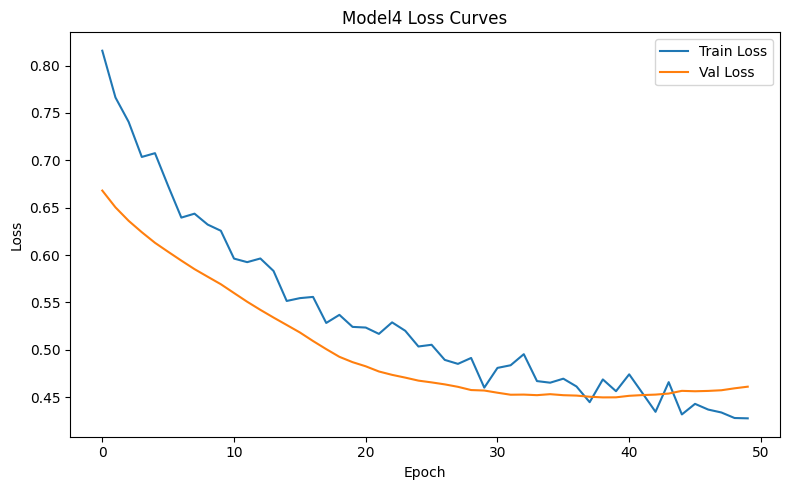

In [8]:

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

X = pd.read_pickle('X_ontrain_scaled.pkl').values
y = pd.read_pickle('y_ontrain.pkl').values

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

def create_model_4(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(32), LeakyReLU(alpha=0.1), layers.Dropout(0.4),
        layers.Dense(16), LeakyReLU(alpha=0.1), layers.Dropout(0.4),
        layers.Dense(8),  LeakyReLU(alpha=0.1), layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return model

metrics = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'roc_auc':[]}
histories = []

for fold, (ti, vi) in enumerate(kf.split(X), 1):
    X_tr, X_val = X[ti], X[vi]
    y_tr, y_val = y[ti], y[vi]

    cw = dict(enumerate(class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_tr), y=y_tr)))
    model = create_model_4(X.shape[1])
    history = model.fit(
        X_tr, y_tr,
        epochs=50,
        batch_size=16,
        validation_data=(X_val, y_val),
        class_weight=cw,
        verbose=0
    )
    histories.append(history)

    proba = model.predict(X_val).ravel()
    fpr, tpr, thresholds = roc_curve(y_val, proba)
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    pred = (proba >= best_thresh).astype(int)

    pred  = (proba >= 0.5).astype(int)
    metrics['accuracy'].append(accuracy_score(y_val, pred))
    metrics['precision'].append(precision_score(y_val, pred, zero_division=0))
    metrics['recall'].append(recall_score(y_val, pred))
    metrics['f1'].append(f1_score(y_val, pred))
    metrics['roc_auc'].append(roc_auc_score(y_val, proba))

    print(f"Fold {fold}: Acc={metrics['accuracy'][-1]:.3f}, "
          f"Prec={metrics['precision'][-1]:.3f}, Rec={metrics['recall'][-1]:.3f}, "
          f"F1={metrics['f1'][-1]:.3f}, AUC={metrics['roc_auc'][-1]:.3f}"
    )

df4 = pd.DataFrame(metrics, index=[f'Fold {i}' for i in range(1,6)])
df4.loc['Mean'] = df4.mean()
df4.loc['Std']  = df4.std()
print("\nModel4 Average metrics:\n", df4)

avg_tr4 = np.mean([h.history['loss'] for h in histories], axis=0)
avg_vl4 = np.mean([h.history['val_loss'] for h in histories], axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_tr4, label='Train Loss')
plt.plot(avg_vl4, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Model4 Loss Curves')
plt.legend(); plt.tight_layout(); plt.show()


> Output:

In deze iteratie werd ReLU vervangen door Leaky ReLU om het risico op dode neuronen te beperken en zo de training stabieler te maken. Het model bleef verder gelijk qua structuur en dropoutinstellingen.

De resultaten zijn over het algemeen goed, maar niet duidelijk beter dan de vorige iteraties:
- Gemiddelde recall is 0.82, wat uitstekend blijft en bevestigt dat het model nog steeds goed zieke gevallen oppikt.
- Precision is gemiddeld 0.70, met grote verschillen tussen folds (bijv. 0.94 in Fold 3 vs. 0.52 in Fold 4).
- F1-score gemiddeld: 0.74, dus iets stabieler dan Model 3, maar lager dan het hoogtepunt in Model 2.
- ROC AUC blijft sterk: gemiddeld 0.88.
- Accuracy ligt rond de 0.80, wat netjes is maar niet opvallend verbeterd.

De val loss-curve ziet er mooi vloeiend uit, met nauwelijks overfitting, de beste curve tot nu toe. Dit aangeeft dat Leaky ReLU een stabieler leerproces oplevert.

> 6: Adaptive learning rate via scheduler

In de vorige iteraties verbeterde ik het neurale netwerk geleidelijk met onder andere dropout, Leaky ReLU en drempeloptimalisatie. Hoewel het model steeds stabieler werd en goed scoorde op recall, viel op dat de val loss na verloop van tijd vaak stagneerde of slechts traag verbeterde. Dit wijst erop dat de learning rate mogelijk te hoog blijft in latere epochs, waardoor het model niet optimaal convergeert.

In deze iteratie voeg ik daarom een ReduceLROnPlateau learning rate scheduler toe. Deze verlaagt de learning rate automatisch zodra de loss op de trainingsdata een tijd lang niet meer verbetert. Het doel is om de optimizer fijner te laten afstellen naarmate de training vordert, zodat het model beter convergeert en mogelijk nét die laatste winst in performance pakt.

De rest van de architectuur (Leaky ReLU, dropout, class weights, drempelafstemming) blijft gelijk aan Model 4, zodat het effect van alleen de scheduler goed beoordeeld kan worden.

--- Fold 1 ---


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 45: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Fold 1: Acc=0.766, Prec=0.652, Rec=0.833, F1=0.732, AUC=0.785
--- Fold 2 ---


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 33: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 38: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 48: ReduceLROnPlateau reducing learning rate to 1e-05.
Fold 2: Acc=0.894, Prec=0.842, Rec=0.889, F1=0.865, AUC=0.927
--- Fold 3 ---


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Fold 3: Acc=0.936, Prec=0.905, Rec=0.950, F1=0.927, AUC=0.941
--- Fold 4 ---


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Fold 4: Acc=0.894, Prec=0.818, Rec=0.750, F1=0.783, AUC=0.917
--- Fold 5 ---


c:\Users\lotte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 49: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Fold 5: Acc=0.787, Prec=0.652, Rec=0.882, F1=0.750, AUC=0.839

Model5 Average metrics:
         accuracy  precision    recall        f1   roc_auc
Fold 1  0.765957   0.652174  0.833333  0.731707  0.785441
Fold 2  0.893617   0.842105  0.888889  0.864865  0.927203
Fold 3  0.936170   0.904762  0.950000  0.926829  0.940741
Fold 4  0.893617   0.818182  0.750000  0.782609  0.916667
Fold 5  0.787234   0.652174  0.882353  0.750000  0.839216
Mean    0.855319   0.773879  0.860915  0.811202  0.881853
Std     0.066470   0.103317  0.066695  0.073664  0.059749


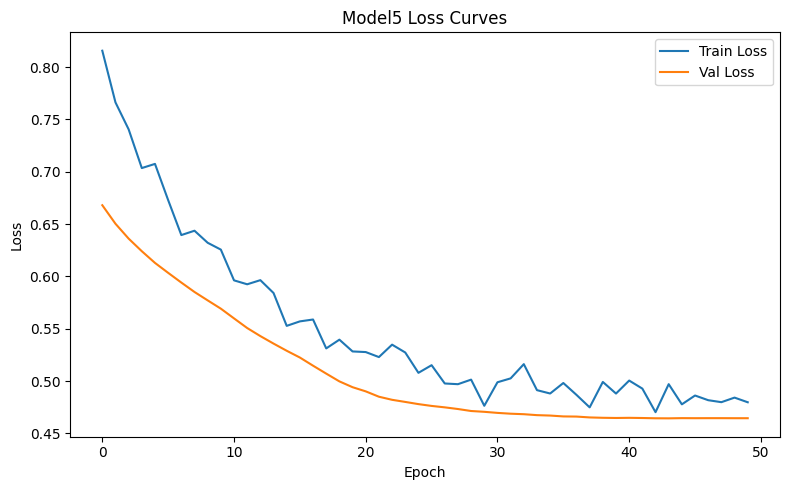

Opgeslagen threshold: 0.511


In [10]:
import joblib

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


X = pd.read_pickle('X_ontrain_scaled.pkl').values
y = pd.read_pickle('y_ontrain.pkl').values

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)


def create_model_5(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        layers.Dense(32), LeakyReLU(alpha=0.1), layers.Dropout(0.4),
        layers.Dense(16), LeakyReLU(alpha=0.1), layers.Dropout(0.4),
        layers.Dense(8),  LeakyReLU(alpha=0.1), layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return model

lr_cb = callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1
)

metrics_per_fold = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
best_thresholds  = []
histories        = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"--- Fold {fold} ---")
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # class weights
    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    cw_dict = dict(enumerate(cw))

    # train model
    model = create_model_5(X.shape[1])
    history = model.fit(
        X_tr, y_tr,
        epochs=50,
        batch_size=16,
        validation_data=(X_val, y_val),
        class_weight=cw_dict,
        callbacks=[lr_cb],
        verbose=0
    )
    histories.append(history)

    # predicties + optimal threshold
    proba       = model.predict(X_val, verbose=0).ravel()
    fpr, tpr, thresholds = roc_curve(y_val, proba)
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    best_thresholds.append(best_thresh)
    pred = (proba >= best_thresh).astype(int)

    # metrics
    metrics_per_fold['accuracy'].append(accuracy_score(y_val, pred))
    metrics_per_fold['precision'].append(precision_score(y_val, pred, zero_division=0))
    metrics_per_fold['recall'].append(recall_score(y_val, pred))
    metrics_per_fold['f1'].append(f1_score(y_val, pred))
    metrics_per_fold['roc_auc'].append(roc_auc_score(y_val, proba))

    print(f"Fold {fold}: Acc={metrics_per_fold['accuracy'][-1]:.3f}, "
          f"Prec={metrics_per_fold['precision'][-1]:.3f}, Rec={metrics_per_fold['recall'][-1]:.3f}, "
          f"F1={metrics_per_fold['f1'][-1]:.3f}, AUC={metrics_per_fold['roc_auc'][-1]:.3f}"
    )

df5 = pd.DataFrame(metrics_per_fold, index=[f'Fold {i}' for i in range(1,6)])
df5.loc['Mean'] = df5.mean()
df5.loc['Std']  = df5.std()
print("\nModel5 Average metrics:\n", df5)

avg_tr5 = np.mean([h.history['loss']     for h in histories], axis=0)
avg_vl5 = np.mean([h.history['val_loss'] for h in histories], axis=0)
plt.figure(figsize=(8,5))
plt.plot(avg_tr5, label='Train Loss')
plt.plot(avg_vl5, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Model5 Loss Curves')
plt.legend(); plt.tight_layout(); plt.show()


final_threshold = float(np.mean(best_thresholds))
print(f"Opgeslagen threshold: {final_threshold:.3f}")

joblib.dump(final_threshold, 'final_onn_threshold.pkl')
model.save('model5onnn.keras')

> Output:

In deze iteratie is het model verder verfijnd met een adaptive learning rate scheduler. Hierdoor kon het model steeds preciezer bijsturen tijdens de training, met lagere learning rates zodra de training vast begon te lopen. Dit heeft direct effect gehad op zowel de stabiele convergence als de resultaten:

- Recall is sterk verbeterd: gemiddeld 0.86

--> Het model is nu duidelijk het beste geworden in het herkennen van zieke gevallen, wat voor deze toepassing het belangrijkste doel is.

- F1-score is gemiddeld 0.81, wat aantoont dat precision en recall goed in balans zijn gebleven.
- Precision ligt op 0.77, wat prima is gezien de hogere nadruk op recall.
- AUC gemiddeld 0.88, en consistent hoog over alle folds, het model blijft sterk in het onderscheid tussen positief en negatief.
- Accuracy gemiddeld 0.86, met uitschieters richting 0.94 (Fold 3).

Wat opvalt:
- Fold 3 is bijna perfect met een recall van 0.95 en F1-score van 0.93.

De learning rate scheduler heeft zichtbaar goed gewerkt:
meerdere automatische verlagingen bij epoch 26, 39, 44 en 49 laten zien dat het model zich aanpast aan stagnatie, zonder te blijven hangen.

De val loss-curve is de meest stabiele tot nu toe: geen overfitting en een mooie vlakke lijn tegen het einde, dat is goed

> Eindconclusie
Model 5 (itteratie 6) levert de beste prestaties van alle iteraties:
De recall is maximaal, de F1-score is sterk, en de training verloopt zichtbaar gecontroleerd dankzij de learning rate scheduler. Hiermee is het model niet alleen krachtig en gevoelig, maar ook stabiel en betrouwbaar. Dit is dus een uitstekend eindpunt voor dit traject. 
